# Gaussian Processes

Suppose we are given a Dataset $\mathcal{D}=\{(x_1,f(x_1)),(x_2,f(x_2)),(x_3,f(x_3))\}$ shown on the left plot below. On the right side are three proposals for $f(x_*)$ given a new datapoint $x_{*}$.

In [1]:
# Imports
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.stats import distributions as pdf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

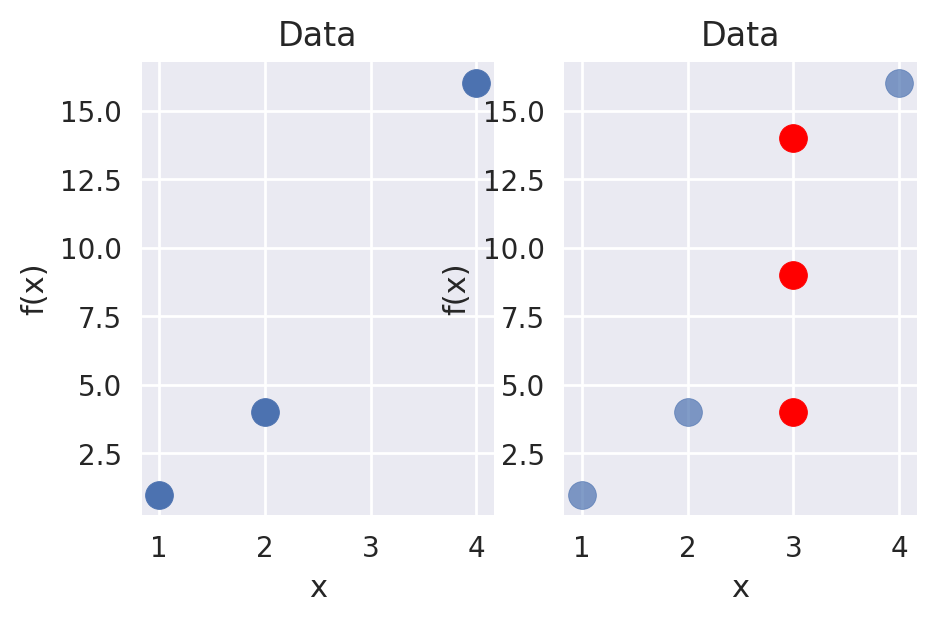

In [2]:
# Example plots
data_x = [1,2,4]
data_fx = [1,4,16]
data_new = [3,3,3]
data_proposed = [4,9,14]
f = plt.figure(dpi=200)
f.set_figheight(3)
f.set_figwidth(5)
f.subplots(1,2)
plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Data',)
plt.scatter(data_x, data_fx, s = 100)
plt.subplot(122)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Data',)
plt.scatter(data_x,data_fx, alpha= 0.7, s = 100)
plt.scatter(data_new,data_proposed, c = 'r', marker = 'o', s = 100)
plt.show()

Most people would argue that the middle red point is the true value belonging to the data generating function. The underlying assumption is that the function is smooth which says that by increasing $x$ by a small amout our function $f(x)$ has to change by a small amount as well. In order to quantify similarity, we need a function that measures similarity between points. Therefore the gaussian kernel is introduced: <br>
<br><center>$K(x_i,x_j)=
e^{-||x_i-x_j||^2} 
$ </center><br>
The gaussian Kernel has useful properties. If the distance between two points goes to zero, $K(x_i,x_j)$ goes to 1. When the points are far away $K(x_i,x_j)$ approaches zero.<br>
Knowing this, we make another assumption, which is: <br>
<br><center>
$f(\mathbf{x})\sim \mathcal{N}(\mathbf{0},\mathbf{K})$,    where $\mathbf{K} =
\begin{pmatrix}
K_{11} & K_{12} &K_{13}\\
K_{21} & K_{22} & K_{23}\\
K_{31} & K_{32} & K_{33}\\
\end{pmatrix}
$
</center><br>
The equation above is our prior distribution. 

# Sampling from the prior distribution

In [3]:
# Interactive prior sampling
# Define the kernel
def gauss_kernel(a, b, sigma):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

@interact(sigma = (0.1,20,0.5), num_samples = (1,15,1), resolution = (10,200,30))
def prior_sampling(sigma, num_samples, resolution):
    x = np.linspace(-5,5,resolution).reshape(-1,1)
    K = gauss_kernel(x,x,sigma) 
    # draw samples from the prior at our test points.
    L = np.linalg.cholesky(K + 1e-6*np.eye(resolution)) #  Choleski Decomposition
    f_prior = np.dot(L, np.random.normal(size=(resolution,num_samples))) #  Sampling
    plt.plot(x, f_prior)
    plt.title('Ten samples from the GP prior')
    plt.axis([-5, 5, -4, 4])
    plt.xlabel('$x$')


interactive(children=(FloatSlider(value=9.6, description='sigma', max=20.0, min=0.1, step=0.5), IntSlider(valu…

$
\begin{pmatrix} f\\f_* \\ \end{pmatrix} = \mathcal{N}(\begin{pmatrix} \mu\\ \mu_* \\ \end{pmatrix}
\begin{pmatrix} K & K_* \\ K_*^T  & K_{**} \end{pmatrix}
$

$\mu_* = \mu(X_*) + K_*^TK^-1(f-\mu(X)) = K_*^TK^-1f $, since we are assuming zero mean.<br>
$\Sigma_* = K_{**}-K_*^TK^-1K_*$

In [4]:
# Data generating function
f = lambda x: np.sin(0.9*x).flatten()

In [5]:
# Interactive Prediction Plot
@interact(num_train=(5,100,5), 
          num_test=(5,100,5), 
          kernel_sigma=(1,10,1), 
          noise=(1,10,1))

def interact_prediction_plot( num_train, num_test, kernel_sigma, noise):
    np.random.seed(1234) #  Seed
    # Scaling
    kernel_sigma *= 0.0001
    noise *= 0.05
    # Input poins + noisy function
    X_train = np.random.uniform(-5, 5, size=(num_train,1))
    y = f(X_train) + noise*np.random.randn(num_train)
    
    # Test points for prediction
    X_test = np.linspace(-5, 5, num_test).reshape(-1,1)
    
    # Similarity matrix + Cholesky
    K = gauss_kernel(X_train,X_train,kernel_sigma) + noise*np.eye(num_train)
    L = np.linalg.cholesky(K)
    
    # Prediction (Mean)
    L_star = np.linalg.solve(L, gauss_kernel(X_train, X_test,kernel_sigma))
    mu_star = np.dot(L_star.T, np.linalg.solve(L, y))
    
    # Uncertainty (Variance)
    K_2star = gauss_kernel(X_test, X_test,kernel_sigma)
    sigma_star = np.diag(K_2star) - np.sum(L_star**2, axis=0)
    sigma_star = np.sqrt(sigma_star)
    
    # PLOTS:
    plt.figure(dpi=100)
    plt.clf()
    plt.plot(X_test, f(X_test), 'b-')
    plt.gca().fill_between(X_test.flat, 
                           mu_star-3*sigma_star, 
                           mu_star+3*sigma_star, 
                           color="#dddddd")
    plt.scatter(X_train,y, c='r', marker='+', s=200)
    plt.plot(X_test, mu_star, 'r--', lw=2)
    plt.title('Mean predictions plus 3 st.deviations')
    plt.legend(('True function','Predicted function','Uncertainty'),frameon=True)
    plt.axis([-5, 5, -3, 3])
    plt.xlabel('$x$')
    plt.ylabel('f(x)')
    plt.show()
    

interactive(children=(IntSlider(value=50, description='num_train', min=5, step=5), IntSlider(value=50, descrip…

# Sampling from the Posterior

Now that we now the parameters $\mu_*$ and $\Sigma_*$ from the posterior distribution, we can compute the cholesky decomposition $L_*^TL_* = \Sigma_*$ and sample from:
\begin{equation}
  f_* \sim \mathcal{N} = (\mu_*,\Sigma_*) = \mu_* + L_* \mathcal{N}(0,\mathbf{I})
\end{equation}

In [6]:
# Interactive posterior samling
@interact(num_train=(5,100,5), 
          num_test=(5,100,5), 
          kernel_sigma=(1,10,1), 
          noise=(1,10,1),
          num_samples=(1,15,1))

def interact_prediction_plot( num_samples,num_train, num_test, kernel_sigma, noise):   
    
    np.random.seed(1234) #  Seed
    # Scaling
    kernel_sigma *= 0.0001
    noise *= 0.05
    # Input poins + noisy function
    X_train = np.random.uniform(-5, 5, size=(num_train,1))
    y = f(X_train) + noise*np.random.randn(num_train)

    # Test points for prediction
    X_test = np.linspace(-5, 5, num_test).reshape(-1,1)

    # Similarity matrix + Cholesky
    K = gauss_kernel(X_train,X_train,kernel_sigma) + noise*np.eye(num_train)
    L = np.linalg.cholesky(K)

    # Prediction (Mean)
    L_star = np.linalg.solve(L, gauss_kernel(X_train, X_test,kernel_sigma))
    mu_star = np.dot(L_star.T, np.linalg.solve(L, y))

    # Uncertainty (Variance)
    K_2star = gauss_kernel(X_test, X_test,kernel_sigma)
    sigma_star = np.diag(K_2star) - np.sum(L_star**2, axis=0)
    sigma_star = np.sqrt(sigma_star)

    # draw samples from the posterior at our test points.
    L_post = np.linalg.cholesky(K_2star + 1e-6*np.eye(num_test) - np.dot(L_star.T, 
                                                                         L_star))
    f_post = mu_star.reshape(-1,1) + np.dot(L_post, 
                                            np.random.normal(size=(num_test,num_samples)))
    plt.plot(X_test, f_post)
    plt.title('Samples from the GP posterior')
    plt.axis([-5, 5, -3, 3])

interactive(children=(IntSlider(value=8, description='num_samples', max=15, min=1), IntSlider(value=50, descri…